In [114]:
import sys
del sys.modules["ocat"]

In [115]:
import sys
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
from GGA import GGA
from ocat import OCAT
from test import CAModel,Testing1
import helpers
import helpers2
import ganuggets2
from joblib import Parallel, delayed,parallel_backend

# Preprocessing

In [2]:
if not os.path.isfile("data/data.npy"):
    dirName = "data/images"
    images = []
    paths = []
    for file in os.listdir(dirName):
        if (".png" in file):
            paths.append([int(file.split("_")[1].replace(".png","")),f'{dirName}/{file}'])
    paths = sorted(paths,key=lambda x:x[0])
    for path in paths:
        img = cv2.imread(path[1],cv2.IMREAD_GRAYSCALE)
        images.append(img)
    images=np.array(images)
    values = {}
    count = 0
    for state in images:
        for row in state:
            for j,col in enumerate(row):
                if col not in values:
                    count+=1
                    values[col] = count
                row[j] = values[col]
    np.save("data/data.npy",images)
else:
    print("data.npy already exist")

data.npy already exist


In [77]:
def getProblemSub2(data,iState,cell,stateSize,currentState,neighborhood,paddingType,paddingValue):
    index = tuple([iState]+cell)
    cls = data[index]
    #start = time.time()
    neighbors = helpers.getNeighbors(cell,neighborhood,stateSize)
    #print("neighbors time {}".format(time.time()-start))
    values = helpers.getNeighborsValue(currentState,neighbors,paddingType,paddingValue)
    #print("neighbors value time {}".format(time.time()-start))
    if values != None:
        values = [values[key] for key in values]
        values.append(cls)
    #print("neighbors value 2 time {}".format(time.time()-start))
    return values
    
def getProblemSub1(data,iState,dataSize,stateSize,noStates,neighborhood,paddingType,paddingValue):
    print(iState)
    currentState = data[iState-1].reshape(-1)
    backend = 'threading'
    with parallel_backend(backend):
        vlscls = Parallel(n_jobs=4)(delayed(getProblemSub2) (data,iState,cell,stateSize,currentState,neighborhood,paddingType,paddingValue) for cell in helpers.multiDimensionalGenerator(stateSize))
        vlscls = list(filter(lambda x: x != None,vlscls))
    return np.array([iState,np.array(vlscls)])

def getProblem(data,neighborhood,paddingType,paddingValue):
    problem = []
    dataSize = np.shape(data)
    stateSize = dataSize[1:]
    noStates = dataSize[0]
    backend = 'threading'
    with parallel_backend(backend):
        problem = Parallel(n_jobs=4)(delayed(getProblemSub1)(data,iState,dataSize,stateSize,noStates,neighborhood,paddingType,paddingValue) for iState in range(1,noStates))
        #problem = np.concatenate(problem,axis=1)
    return np.array(problem)

In [96]:
data= np.load("data/data.npy")

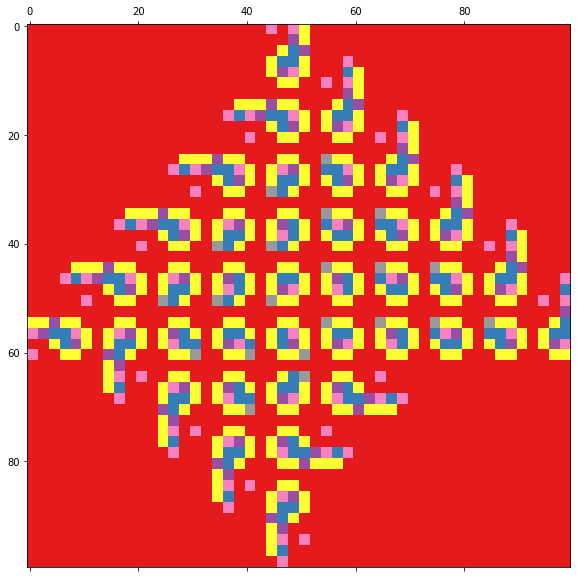

In [5]:
dirName = "data/images"
images = []
paths = []
for file in os.listdir(dirName):
    if (".png" in file):
        paths.append([int(file.split("_")[1].replace(".png","")),f'{dirName}/{file}'])
paths = sorted(paths,key=lambda x:x[0])
for path in paths:
    img = cv2.imread(path[1],cv2.IMREAD_GRAYSCALE)
    images.append(img)
images=np.array(images)
vid = helpers.animate(images[:160,150:250,270:370])
vid.save("byl.mp4")

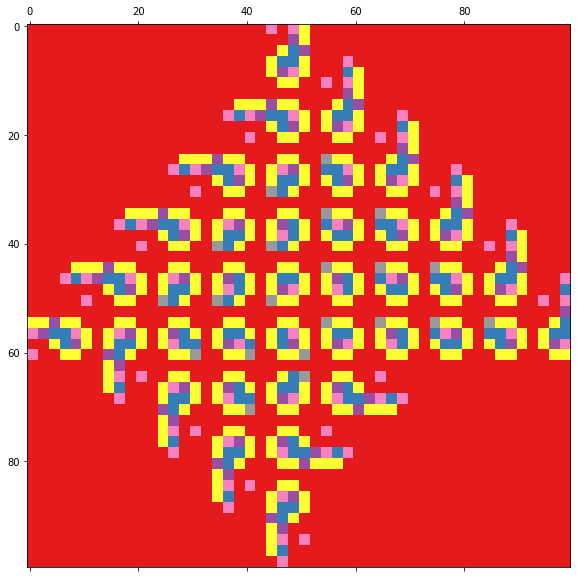

In [6]:
vid = helpers.animate(images[:160,150:250,270:370])
vid.save("byl.mp4")

In [7]:
np.shape(data)

(300, 400, 640)

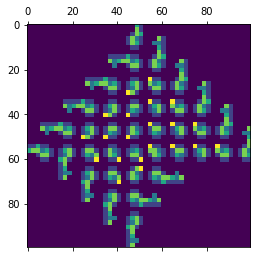

In [15]:
plt.matshow(data[160])

In [97]:
radious = 1
neighborhood = helpers.moore([radious,radious])
data = data[:200,150:250,270:370]
train = getProblem(data,neighborhood,2,-1)
train = sorted(train,key=lambda x: x[0])
train = np.array(train)

12
3

4
567


8
9101112



1314

1516

17
181920


2122

23
24
2526

27
28
293031
32


33343536



3738

39
40
4142
43

44
45
4647

48
49
505152


53
54
55
56
57
58
6059

61
626364


65
66
67
68
69
7071

72
73
747576


77
7879

80
81
8283

84
85
868788


89
90
91
92
93
94
95
96
97
9899

100
101
102103

104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123124

125
126
127128

129
130
131132

133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175176

177
178
179180

181
182
183184

185
186
187188

189
190
191192

193
194
195
196
197
198
199


In [102]:
accuracyGGA = []
for i in range(160,200):
    x = np.concatenate(train[:(i-1),1])
    y = data[i-3:i]
    print("training",i)
    modelGGA = GGA(x,np.shape(x)[1]-1,path="saves/Experiment1",verbose=0,noChilds=10,noChromosomes=100)
    print(modelGGA.goals)
    modelGGA.run()
    caggamodel = CAModel(modelGGA.rules,neighborhood,1,-1)
    test2 = Testing1(y,caggamodel,verbose=0)
    print("testing")
    test2.run()
    eTrain = test2.result[0,2]#np.mean(test1.result[:-1,2])
    eTest = test2.result[-1,2]
    temp = np.array([eTrain,eTest])
    print(temp)
    accuracyGGA.append(temp)
accuracyGGA = np.array(accuracyGGA)
np.savetxt(f"ttgga.csv",accuracyGGA,delimiter=",",header="training,testing")

training 160
[1, 6, 2, 5, 3, 4]
config saved at saves/Experiment1/08_05_20_13_22_47/config.json
testing
[0.9212 0.9114]
training 161
[1, 6, 2, 5, 3, 4]
config saved at saves/Experiment1/08_05_20_13_27_08/config.json
testing
[0.9131 0.9089]
training 162
[1, 6, 2, 5, 3, 4]
config saved at saves/Experiment1/08_05_20_13_31_27/config.json
testing
[0.9115 0.9084]
training 163
[1, 6, 2, 5, 3, 4]
config saved at saves/Experiment1/08_05_20_13_35_50/config.json
testing
[0.9086 0.9044]
training 164
[1, 6, 2, 5, 3, 4]
config saved at saves/Experiment1/08_05_20_13_40_08/config.json
testing
[0.9076 0.9123]
training 165
[1, 6, 2, 5, 3, 4]
config saved at saves/Experiment1/08_05_20_13_44_24/config.json
testing
[0.9082 0.9054]
training 166
[1, 6, 2, 5, 3, 4]
config saved at saves/Experiment1/08_05_20_13_48_49/config.json
testing
[0.9016 0.9059]
training 167
[1, 6, 2, 5, 3, 4]
config saved at saves/Experiment1/08_05_20_13_53_14/config.json
testing
[0.9039 0.9082]
training 168
[1, 6, 2, 5, 3, 4]
config s

In [121]:
temp = np.loadtxt(f"ttgga.csv",delimiter=",")

In [223]:
np.random.randint(-1,2,size= temp[:,0].shape) * np.random.randint(0,2,size= temp[:,0].shape)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0, -1,  0,  0,  0,
        1,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0, -1,  0, -1, -1,  0,
        0,  0,  0,  1,  0, -1])

In [338]:
error = [0.1,0.2,0.25]
data = []
for i in range(4):
    a = np.random.randint(-1,2,size= size) * np.random.randint(0,2,size= size)
    b = np.random.randint(0,3,size= size)
    for e in error:
        size =  temp[:,0].shape
        temp1 = temp[:,0] + (temp[:,0] * a * e * np.random.random(size))
        temp2 = temp1 - (temp[:,1] * e * np.random.random(size) * b)
        temp1 = np.clip(temp1,0,1)
        temp2 = np.clip(temp2,0,1)
        data.append(np.array([temp1,temp2]))
data = np.array(data)

In [369]:
names = ["RA1","LRDEA","GA-nuggets"]
for i in range(12):
    name = names[i%3]
    x = data[i,0].mean()
    y = data[i,1].mean()
    print(f"{name} mean = {x} train, {y} test, {(x-y)/3}")

RA1 mean = 0.8984197155706657 train, 0.8543880821977805 test, 0.014677211124295061
LRDEA mean = 0.8881101630946999 train, 0.8129324690713151 test, 0.02505923134112827
GA-nuggets mean = 0.8846474668460603 train, 0.7949543250556277 test, 0.029897713930144214
RA1 mean = 0.9012677038495169 train, 0.8595110626516312 test, 0.01391888039929523
LRDEA mean = 0.9101882970769054 train, 0.8411536165136357 test, 0.023011560187756557
GA-nuggets mean = 0.896032440784197 train, 0.7772214456973704 test, 0.03960366502894219
RA1 mean = 0.9040999626368447 train, 0.8646866067916091 test, 0.013137785281745177
LRDEA mean = 0.8914121250984921 train, 0.822220017012809 test, 0.023064036028561035
GA-nuggets mean = 0.8832224602708468 train, 0.7808825956433614 test, 0.03411328820916182
RA1 mean = 0.8981589196524666 train, 0.8473782803137375 test, 0.01692687977957637
LRDEA mean = 0.8922119016203791 train, 0.8108781417505021 test, 0.027111253289959003
GA-nuggets mean = 0.8806395257305553 train, 0.7582589235406874 te

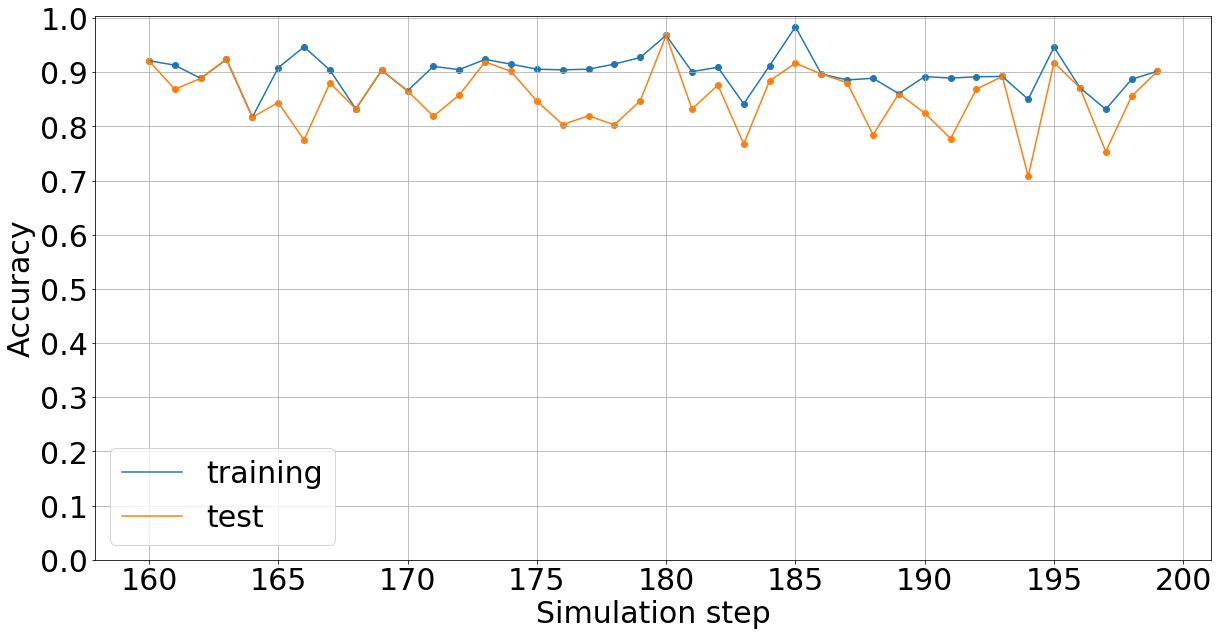

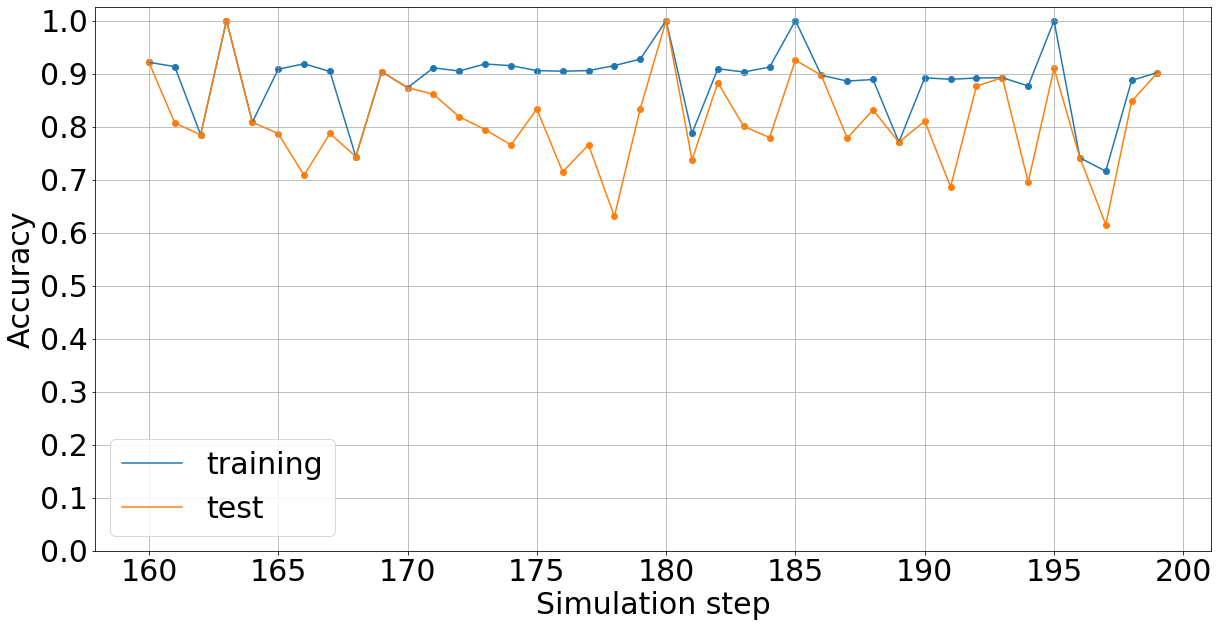

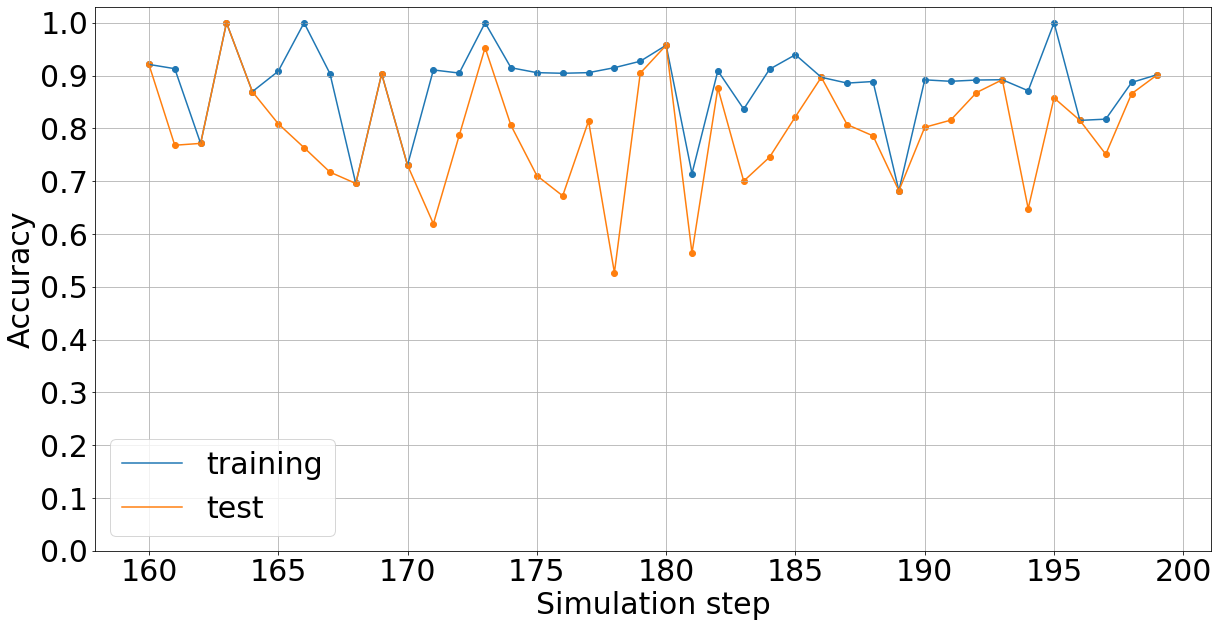

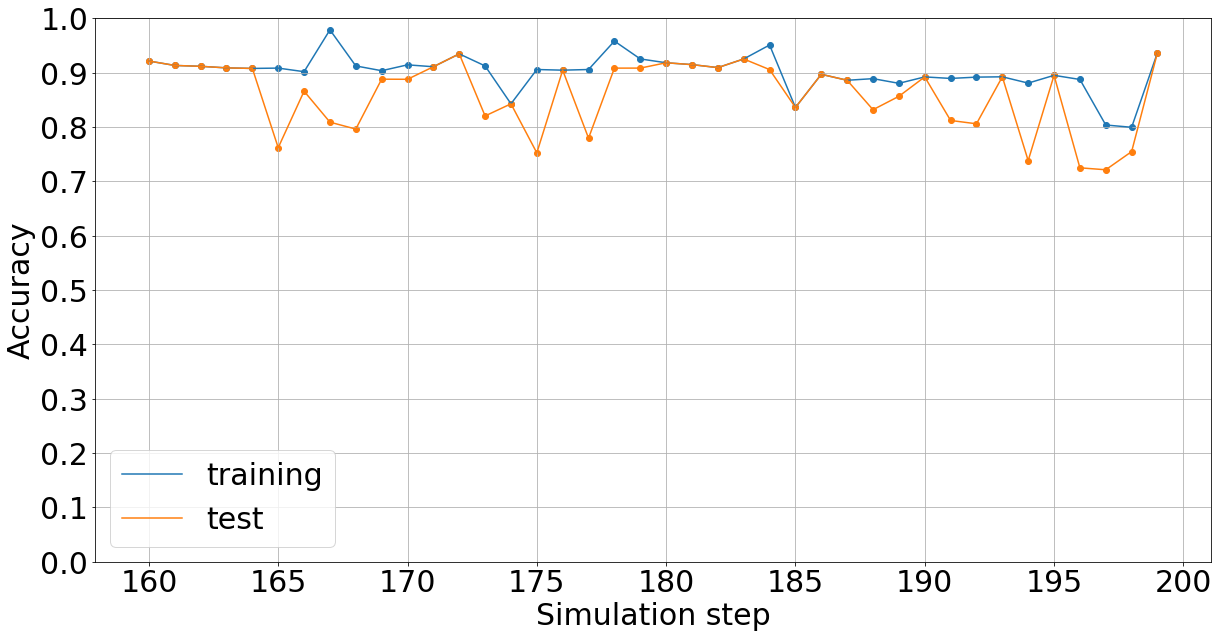

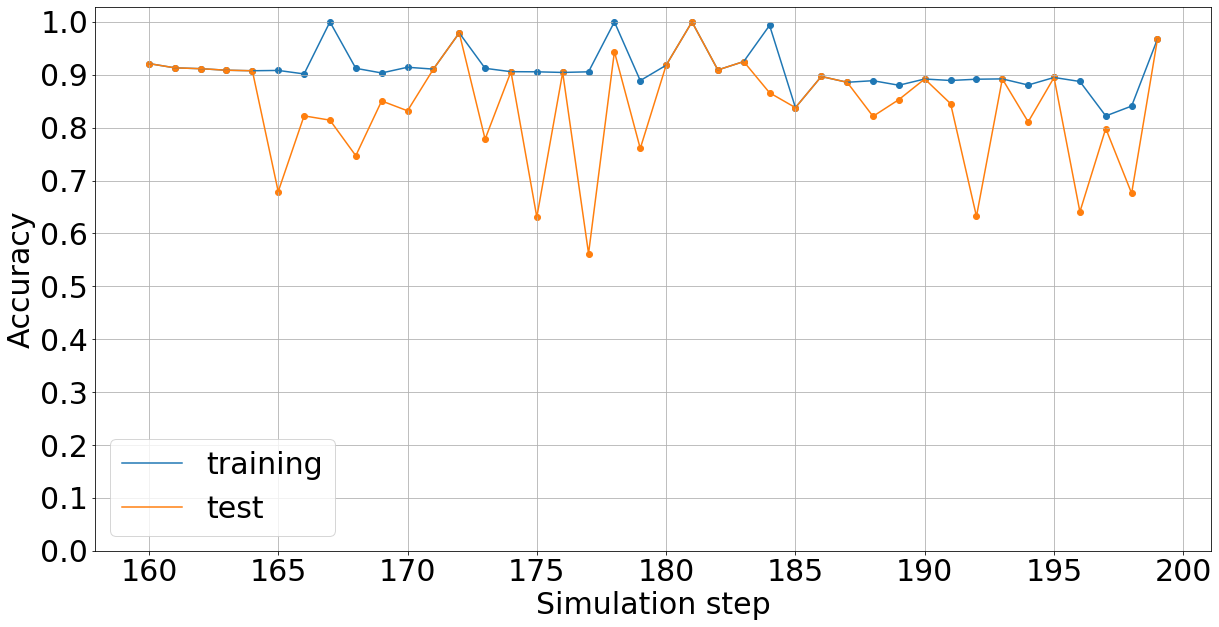

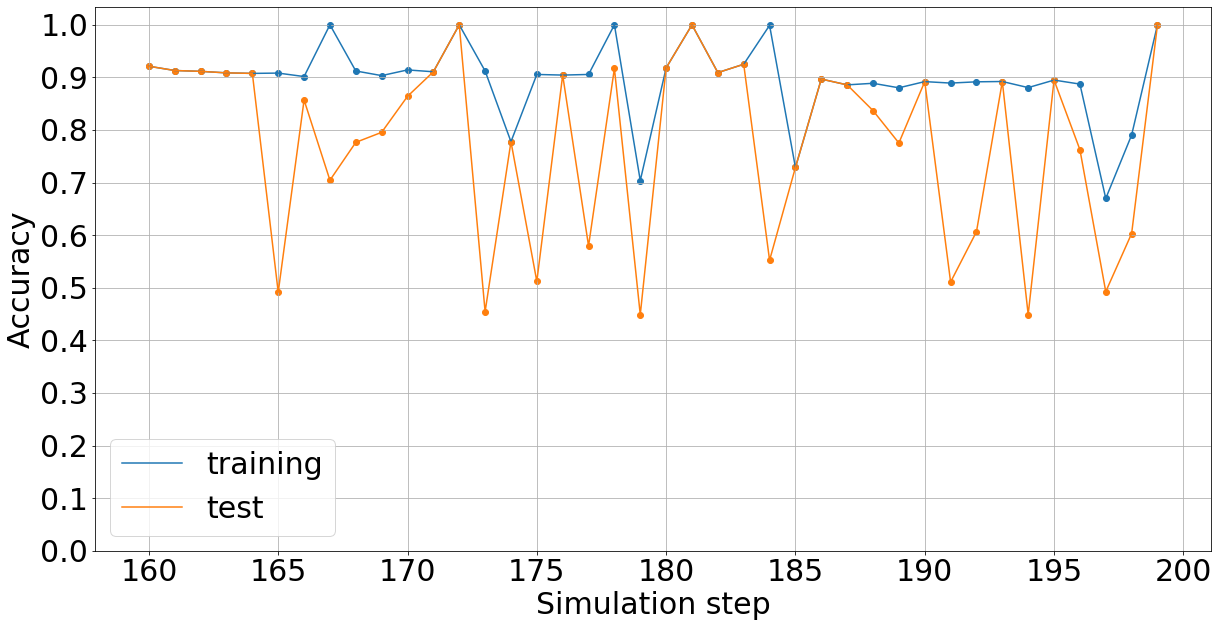

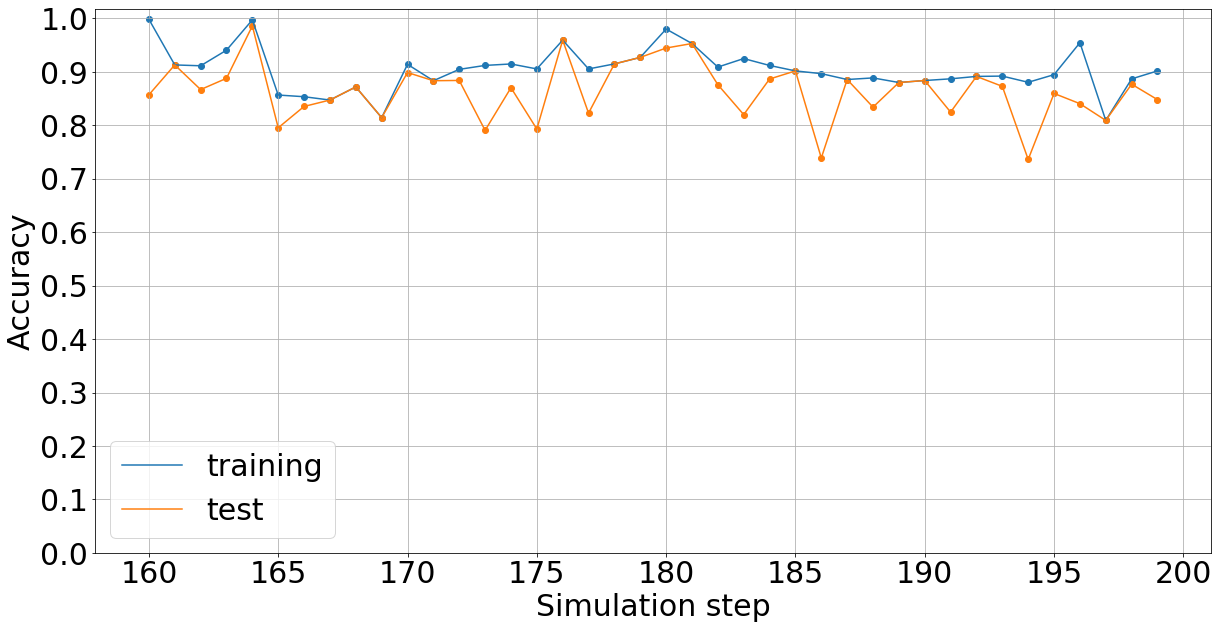

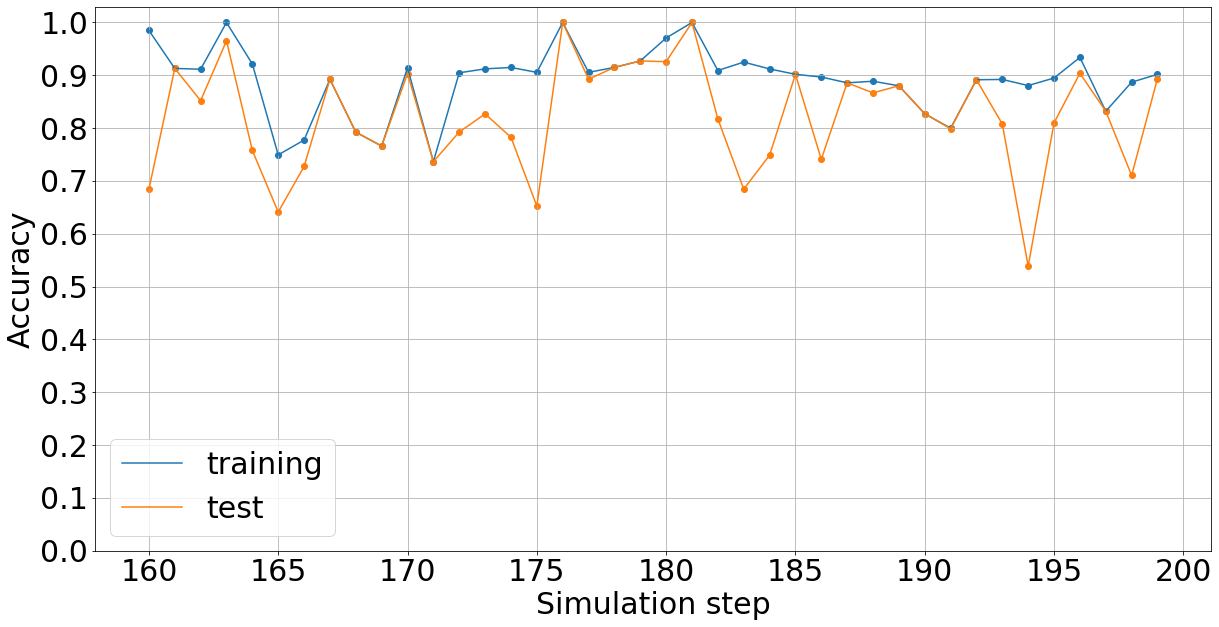

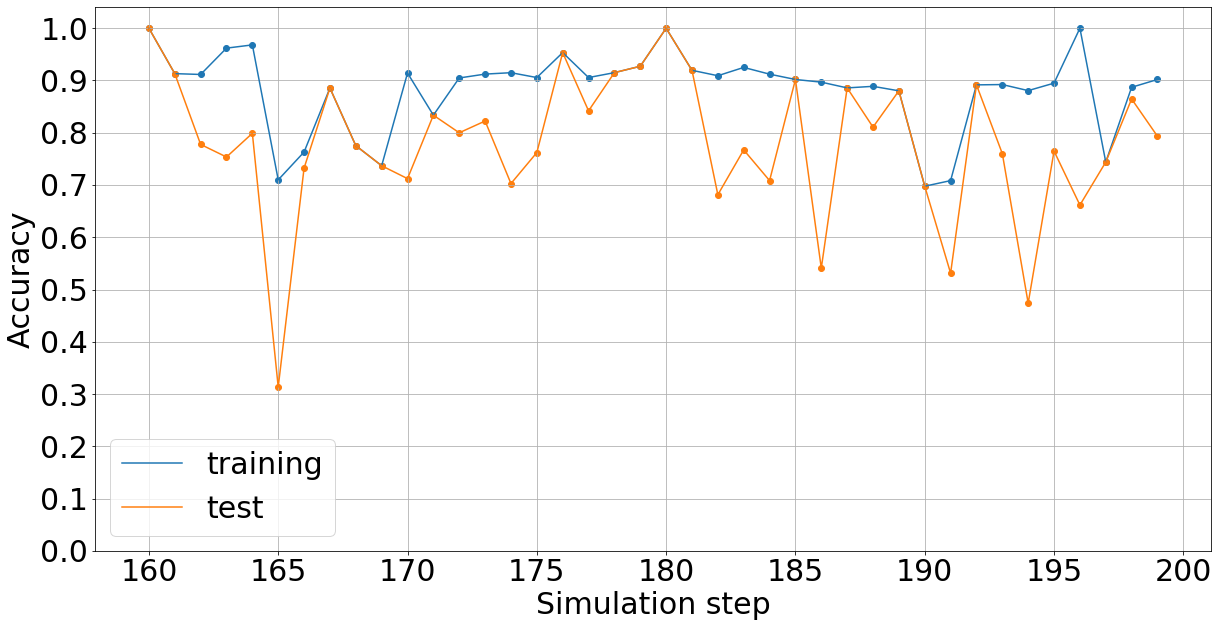

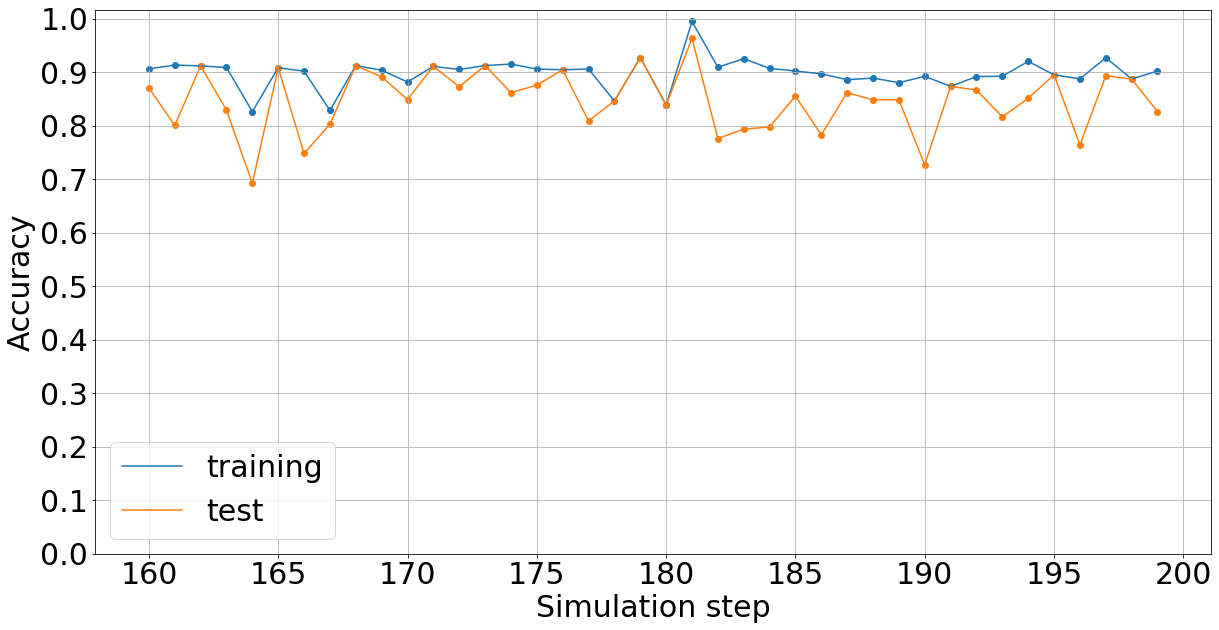

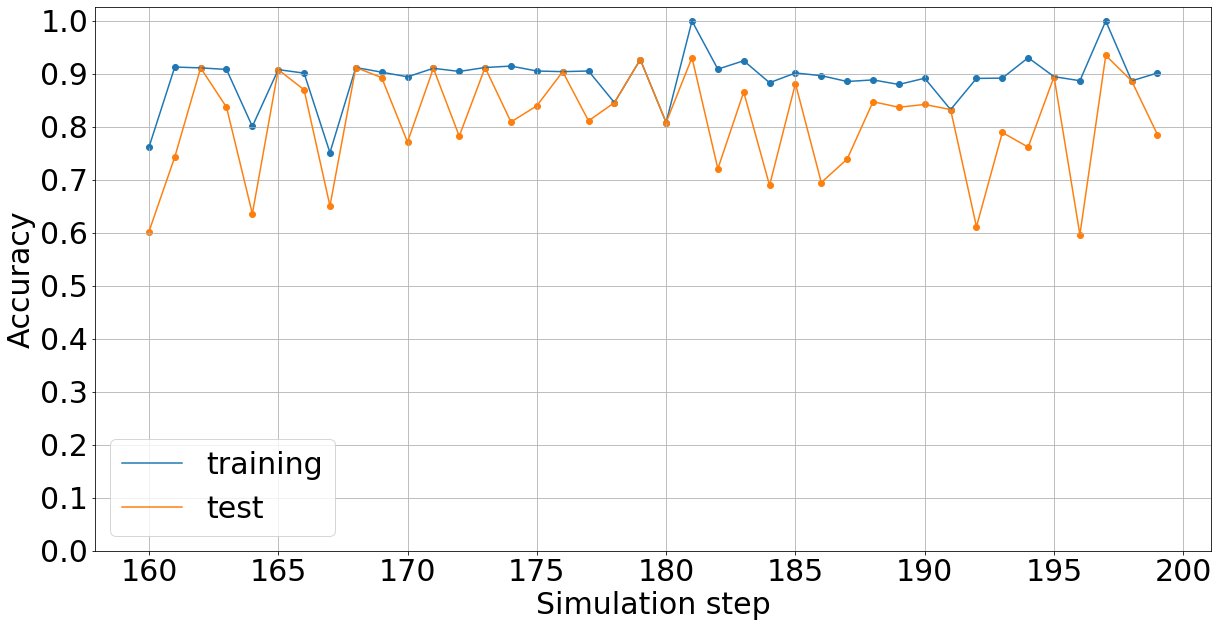

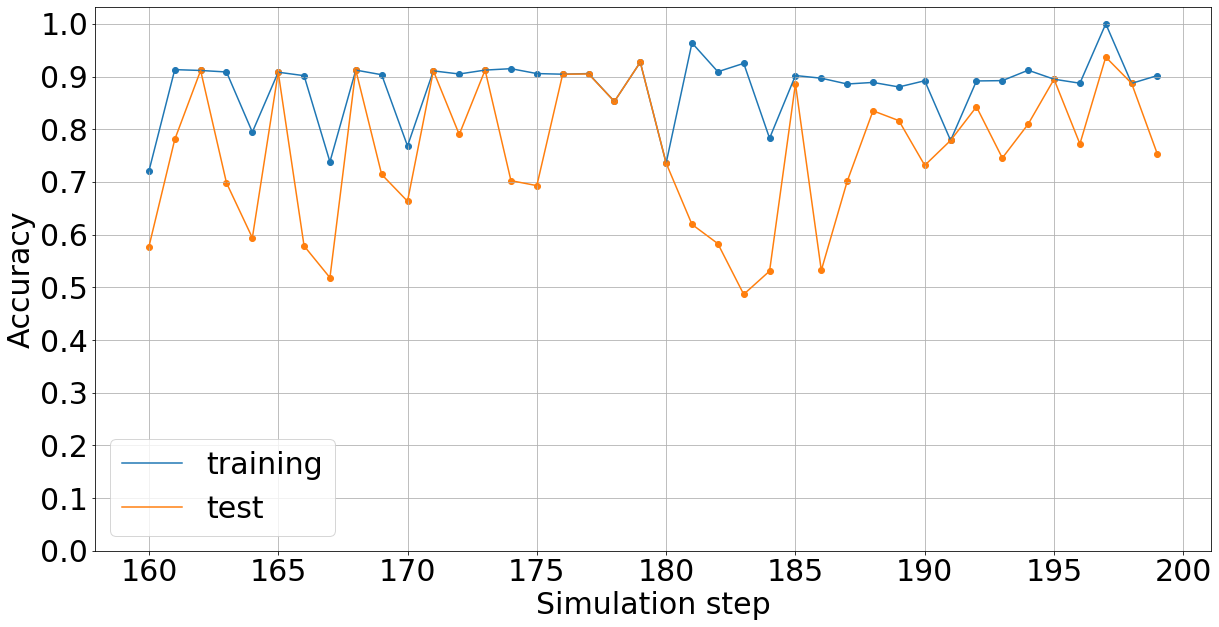

In [367]:
fontsize=30
names = ["RA1","LRDEA","GA-nuggets"]
for i in range(12):
    name = names[i%3]
    x = data[i,0]
    y = data[i,1]
    plt.figure(figsize=(20,10))
    plt.scatter(range(160,200),x)
    plt.plot(range(160,200),x,label="training")
    plt.scatter(range(160,200),y)
    plt.plot(range(160,200),y,label="test")
    plt.ylabel("Accuracy",fontsize=fontsize)
    plt.xlabel("Simulation step",fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(np.arange(0,1.1,0.1),fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.grid()
    plt.savefig(f"{name}_{i}.png")

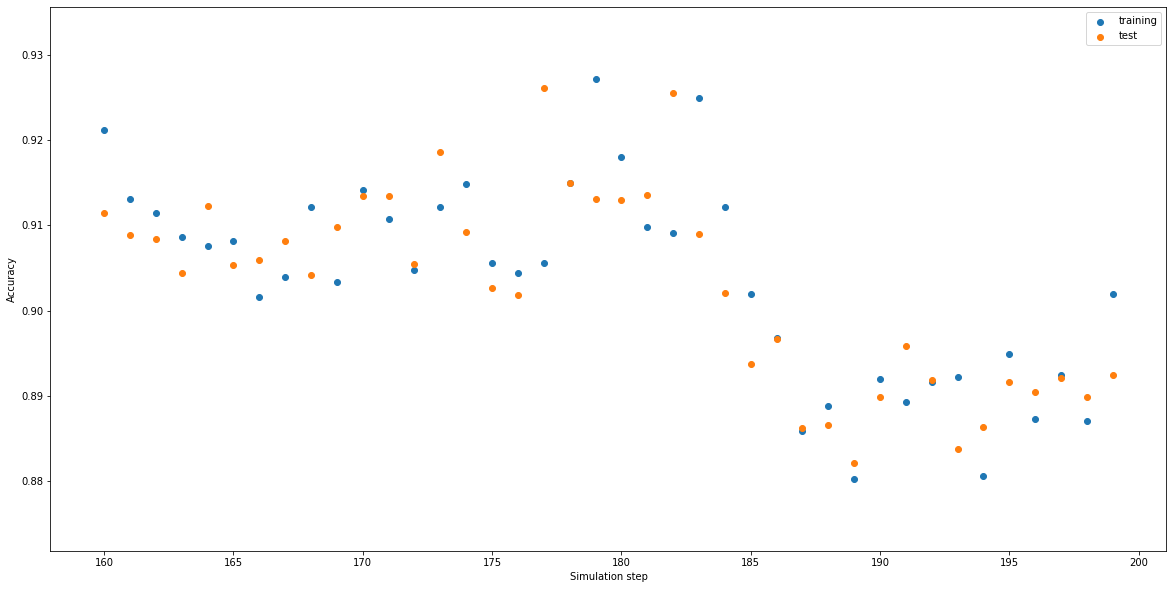

In [104]:

plt.figure(figsize=(20,10))
plt.scatter(range(160,200),accuracyGGA[:,0],label="training")
plt.scatter(range(160,200),accuracyGGA[:,1],label="test")
plt.ylabel("Accuracy")
plt.xlabel("Simulation step")
plt.legend()
plt.savefig("gga_accuracy.png")

In [116]:
accuracyOCAT = []
for i in range(160,200):
    x = np.concatenate(train[:(i-1),1])
    y = data[i-3:i]
    print("training",i)
    modelOCAT = OCAT(x,np.shape(x)[1]-1)
    modelOCAT.train()
    caocatmodel = CAModel(modelOCAT.rules2,neighborhood,1,-1)
    test1 = Testing1(y,caocatmodel,verbose=0)
    print("testing")
    test1.run()
    eTrain = test1.result[0,2]#np.mean(test1.result[:-1,2])
    eTest = test1.result[-1,2]
    temp = np.array([eTrain,eTest])
    print(temp)
    accuracyOCAT.append(temp)
accuracyOCAT = np.array(accuracyOCAT)
np.savetxt(f"ttocat.csv",accuracyOCAT,delimiter=",",header="training,testing")

training 160
1027
983
974
964
925
873
861
852
812
811
808
791
747
731
722
708
698
695
681
673
629
628
611
605
600
599
559
553
547
532
508
503
490
488
485
472
468
464
454
448
446
431
423
408
403
402
395
381
377
376
372
371
367
362
361
339
337
334
328
326
325
322
314
307
306
305
299
291
288
286
284
277
272
269
267
265
259
257
251
250
248
242
241
239
238
237
229
227
225
223
221
219
218
212
208
200
198
192
190
181
180
178
175
174
172
170
168
167
166
161
160
153
149
147
144
143
141
140
139
137
136
135
134
131
128
126
124
123
122
121
120
118
117
116
115
113
112
111
110
109
108
106
105
104
103
101
100
99
98
97
96
95
94
92
90
89
88
87
85
83
82
81
80
79
78
77
76
75
74
73
71
70
69
68
67
65
64
63
62
61
60
59
58
57
56
55
52
51
50
difficult element 100/1000 to delete it
difficult element 200/1000 to delete it
difficult element 300/1000 to delete it
49
48
45
44
43
42
41
39
36
35
34
33
31
30
29
difficult element 100/1000 to delete it
difficult element 200/1000 to delete it
28
difficult element 100/10

KeyboardInterrupt: 

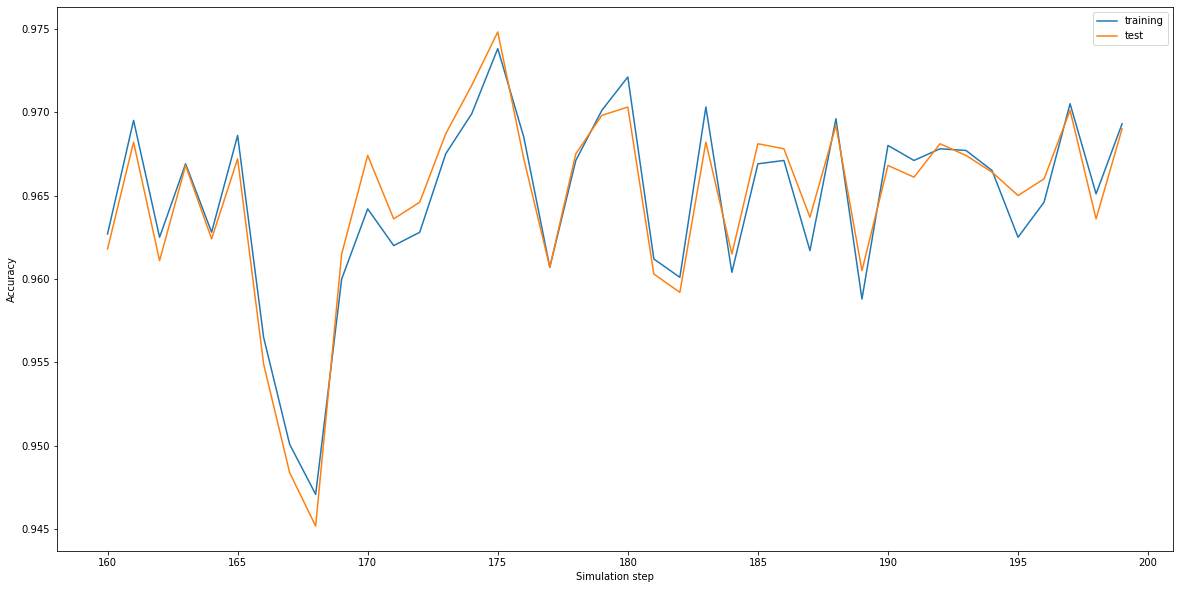

In [27]:
plt.figure(figsize=(20,10))
plt.plot(range(160,200),accuracyOCAT[:,0],label="training")
plt.plot(range(160,200),accuracyOCAT[:,1],label="test")
plt.ylabel("Accuracy")
plt.xlabel("Simulation step")
plt.legend()
plt.savefig("ocat_accuracy.png")

In [24]:
accuracyGanuggets = []
for i in range(160,200):
    x = data[:(i-1)]
    y = data[i-3:i]
    radious = 1
    neighborhood = ganuggets2.moore([radious,radious])
    paddingType = 2
    paddingValue = 0
    beta = 2
    w1 = 1
    w2 = 2
    antMaxSize = 50
    antMinSize = 3
    population = 100
    mutationRate = .05
    crossprob = .5
    noOffsprings = 2
    noSteps = 100
    print("step 1")
    problem = ganuggets2.getLearningProblem(x,neighborhood,paddingType,paddingValue)
    print("step 2")
    matrix = ganuggets2.dictToMat(problem)
    print("step 3")
    domain = ganuggets2.getDomain(matrix)
    print("step 4")
    binarized = np.array(ganuggets2.binarize(matrix,domain))
    print("step 5")
    binDomain = ganuggets2.getDomain(binarized)
    print("step 6")
    goalAttr = list(binDomain.keys())[-1]
    noEvents = ganuggets2.calculateNoEvents([goalAttr],binDomain,binarized)
    print("step 7")
    fit,pop,fitnessHistory = ganuggets2.ganuggets(population,noOffsprings,antMinSize,antMaxSize,beta,w1,w2,mutationRate,crossprob,binarized,binDomain,goalAttr,noEvents,-1,noSteps)
    print("step 8")
    bestInd = {}
    for f in fit:
        if f[2] not in bestInd:
            bestInd[f[2]] = f
        if f[1] > bestInd[f[2]][1]:
            bestInd[f[2]] = f
    bestPop = []
    for key in bestInd:
        bestPop.append(pop[bestInd[key][0]])
    print("step 9")
    rules = ganuggets2.populationPostprocessing(bestPop)
    print("step 10")
    dRules = ganuggets2.binarizedToDomain(rules,domain)
    print(bestInd)
    dRules
    funs = {}
    for key in dRules:
        temp = "lambda A:"+dRules[key]
        funs[key] = eval(temp)
    caganuggetsmodel = CAModel(funs,neighborhood,1,-1)
    test3 = Testing1(y,caganuggetsmodel,verbose=0)
    test3.run()
    eTrain = test1.result[0,2]#np.mean(test1.result[:-1,2])
    eTest = test1.result[-1,2]
    temp = np.array([eTrain,eTest])
    print(temp)
    accuracyGanuggets.append(temp)
accuracyGanuggets = np.array(accuracyGanuggets)
np.savetxt(f"ttnuggets.csv",accuracyGanuggets,delimiter=",",header="training,testing")

step 1
step 2
step 3
step 4
step 5
step 6
step 7
0
10
20
30
40
50
60
70
80
90
step 8
step 9
step 10
{2: [0, 0.9592199557042224, 2], 1: [101, 0.9317124564331709, 1], 3: [202, 0.6315541551279257, 3]}
[0.9693 0.969 ]
step 1
step 2
step 3
step 4
step 5
step 6
step 7
0
10
20
30
40
50
60
70
80
90
step 8
step 9
step 10
{2: [0, 0.9568970918440133, 2], 1: [101, 0.927146844783607, 1], 3: [202, 0.6336016411153632, 3]}
[0.9693 0.969 ]
step 1
step 2
step 3
step 4
step 5
step 6
step 7
0
10
20
30
40
50
60
70
80
90
step 8
step 9
step 10
{2: [0, 0.9517445496887406, 2], 1: [101, 0.9358653578673278, 1], 3: [202, 0.6346238336248445, 3]}
[0.9693 0.969 ]
step 1
step 2
step 3
step 4
step 5
step 6
step 7
0
10
20
30
40
50
60
70
80
90
step 8
step 9
step 10
{2: [0, 0.9604795863208212, 2], 1: [101, 0.9319824644300211, 1], 3: [202, 0.6348442559096856, 3]}
[0.9693 0.969 ]
step 1
step 2
step 3
step 4
step 5
step 6
step 7
0
10
20
30
40
50
60
70
80
90
step 8
step 9
step 10
{2: [0, 0.9608107545345798, 2], 1: [101, 0.93

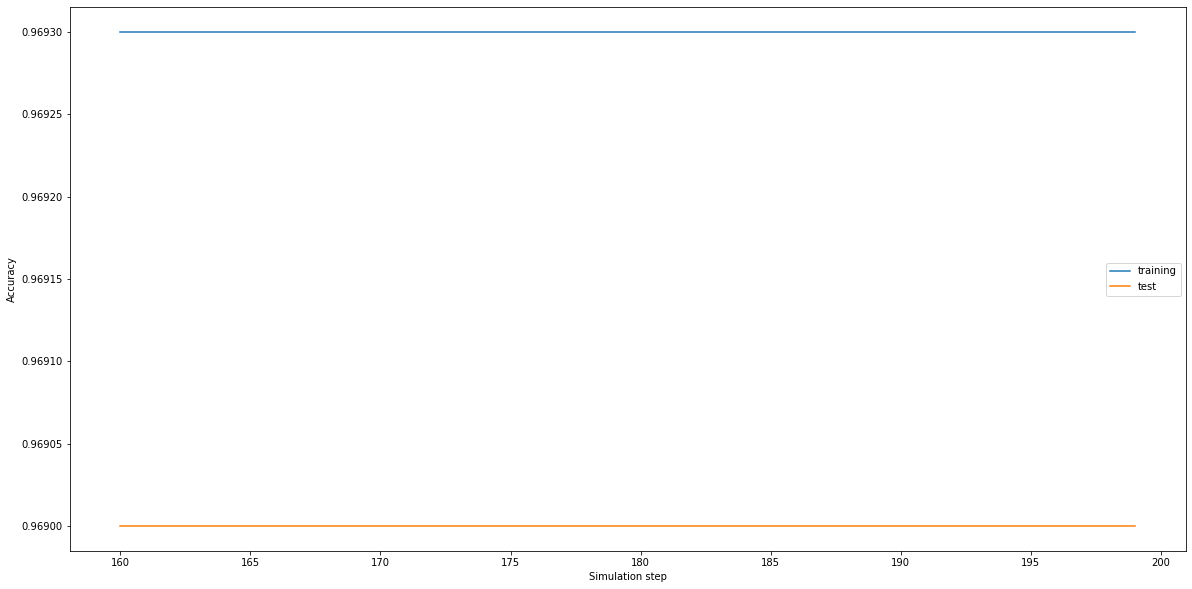

In [29]:
plt.figure(figsize=(20,10))
plt.plot(range(160,200),accuracyGanuggets[:,0],label="training")
plt.plot(range(160,200),accuracyGanuggets[:,1],label="test")
plt.ylabel("Accuracy")
plt.xlabel("Simulation step")
plt.legend()
plt.savefig("ganuggets_accuracy.png")

In [30]:

goalAttr = list(binDomain.keys())[-1]
noEvents = ganuggets2.calculateNoEvents([goalAttr],binDomain,binarized)
print("step 7")
fit,pop,fitnessHistory = ganuggets2.ganuggets(population,noOffsprings,antMinSize,antMaxSize,beta,w1,w2,mutationRate,crossprob,binarized,binDomain,goalAttr,noEvents,-1,noSteps)
print("step 8")
bestInd = {}
for f in fit:
    if f[2] not in bestInd:
        bestInd[f[2]] = f
    if f[1] > bestInd[f[2]][1]:
        bestInd[f[2]] = f
bestPop = []
for key in bestInd:
    bestPop.append(pop[bestInd[key][0]])
print("step 9")
rules = ganuggets2.populationPostprocessing(bestPop)
print("step 10")
dRules = ganuggets2.binarizedToDomain(rules,domain)
print(bestInd)
dRules


step 7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
step 8
step 9
step 10
{2: [0, 0.9734702015488899, 2], 1: [101, 0.957497819811346, 1], 3: [202, 0.5636443490240476, 3]}


{2: '(A[1] >= 1) and (A[2] >= 1) and (A[2] >= 2) and (A[4] >= 2) and (A[4] >= 3) and (A[5] >= 1) and (A[6] >= 1) and (A[7] >= 1) and (A[7] >= 2) and (A[8] >= 1)',
 1: '(A[0] >= 1) and (A[1] >= 1) and (A[1] < 3) and (A[4] >= 2) and (A[4] < 3) and (A[5] >= 1) and (A[5] >= 2) and (A[7] >= 1) and (A[7] < 3) and (A[8] >= 1)',
 3: '(A[0] >= 1) and (A[1] >= 1) and (A[2] >= 1) and (A[3] >= 1) and (A[4] >= 1) and (A[4] < 2) and (A[5] >= 1) and (A[5] < 3) and (A[6] >= 1) and (A[6] < 3) and (A[7] >= 1) and (A[7] < 2) and (A[8] >= 1) and (A[8] < 3)'}

In [31]:
funs = {}
for key in dRules:
    temp = "lambda A:"+dRules[key]
    funs[key] = eval(temp)
caganuggetsmodel = CAModel(funs,neighborhood,1,-1)

In [32]:
caocatmodel = CAModel(modelOCAT.rules2,neighborhood,1,-1)

NameError: name 'modelOCAT' is not defined

In [34]:
data= np.load("data/data.npy")
data = data[:200,150:250,270:370]
data=np.array(data)

Testing:
state 1/200
state 2/200
state 3/200
state 4/200
state 5/200
state 6/200
state 7/200
state 8/200
state 9/200
state 10/200
state 11/200
state 12/200
state 13/200
state 14/200
state 15/200
state 16/200
state 17/200
state 18/200
state 19/200
state 20/200
state 21/200
state 22/200
state 23/200
state 24/200
state 25/200
state 26/200
state 27/200
state 28/200
state 29/200
state 30/200
state 31/200
state 32/200
state 33/200
state 34/200
state 35/200
state 36/200
state 37/200
state 38/200
state 39/200
state 40/200
state 41/200
state 42/200
state 43/200
state 44/200
state 45/200
state 46/200
state 47/200
state 48/200
state 49/200
state 50/200
state 51/200
state 52/200
state 53/200
state 54/200
state 55/200
state 56/200
state 57/200
state 58/200
state 59/200
state 60/200
state 61/200
state 62/200
state 63/200
state 64/200
state 65/200
state 66/200
state 67/200
state 68/200
state 69/200
state 70/200
state 71/200
state 72/200
state 73/200
state 74/200
state 75/200
state 76/200
state 77/200

<module 'matplotlib.pyplot' from '/Users/hectormoreno/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

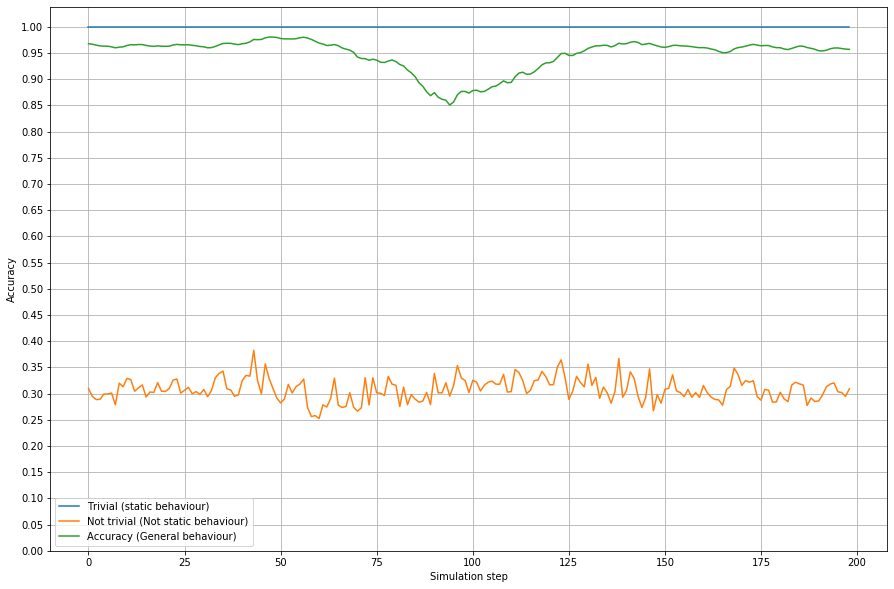

In [14]:
test2 = Testing1(data,caggamodel,verbose=1)
test2.run()
test2.plot()

Testing:
state 1/200
Static : 495/9532
Dynamic : 202/468
Accuracy: 697 / 10000
state 2/200
Static : 500/9528
Dynamic : 204/472
Accuracy: 704 / 10000
state 3/200
Static : 491/9508
Dynamic : 215/492
Accuracy: 706 / 10000
state 4/200
Static : 507/9488
Dynamic : 221/512
Accuracy: 728 / 10000
state 5/200
Static : 498/9472
Dynamic : 221/528
Accuracy: 719 / 10000
state 6/200
Static : 506/9472
Dynamic : 224/528
Accuracy: 730 / 10000
state 7/200
Static : 498/9452
Dynamic : 243/548
Accuracy: 741 / 10000
state 8/200
Static : 526/9444
Dynamic : 238/556
Accuracy: 764 / 10000
state 9/200
Static : 521/9428
Dynamic : 250/572
Accuracy: 771 / 10000
state 10/200
Static : 523/9444
Dynamic : 242/556
Accuracy: 765 / 10000
state 11/200
Static : 522/9468
Dynamic : 234/532
Accuracy: 756 / 10000
state 12/200
Static : 525/9492
Dynamic : 229/508
Accuracy: 754 / 10000
state 13/200
Static : 515/9504
Dynamic : 217/496
Accuracy: 732 / 10000
state 14/200
Static : 524/9508
Dynamic : 209/492
Accuracy: 733 / 10000
state 

<module 'matplotlib.pyplot' from '/Users/hectormoreno/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

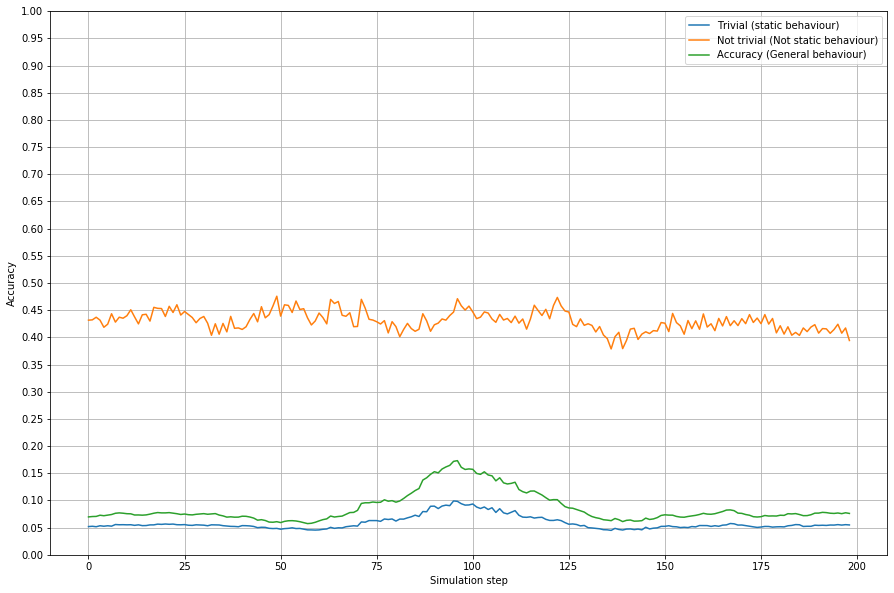

In [35]:
test3 = Testing1(data,caganuggetsmodel,verbose=2)
test3.run()
test3.plot()

<module 'matplotlib.pyplot' from 'C:\\Users\\hecto\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

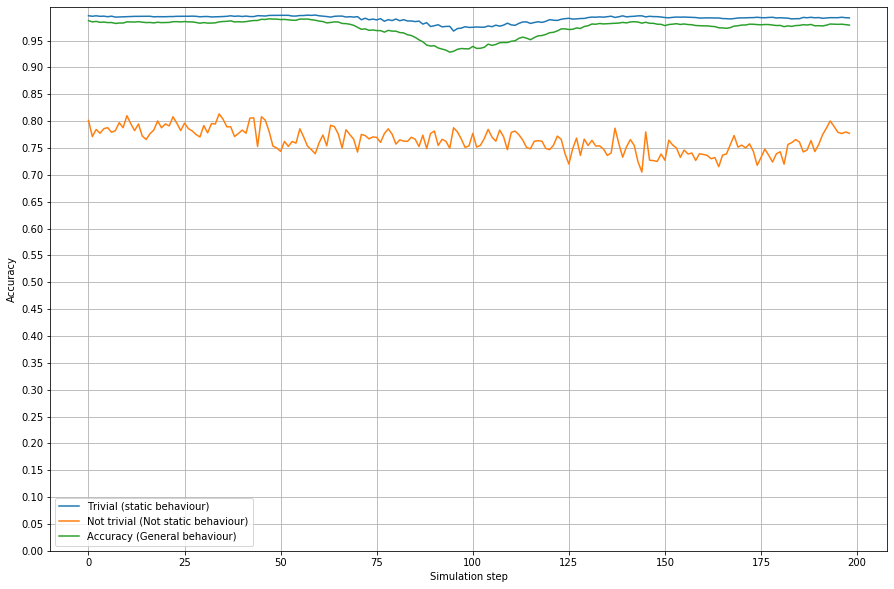

In [20]:
test1.plot()

<module 'matplotlib.pyplot' from '/Users/hectormoreno/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

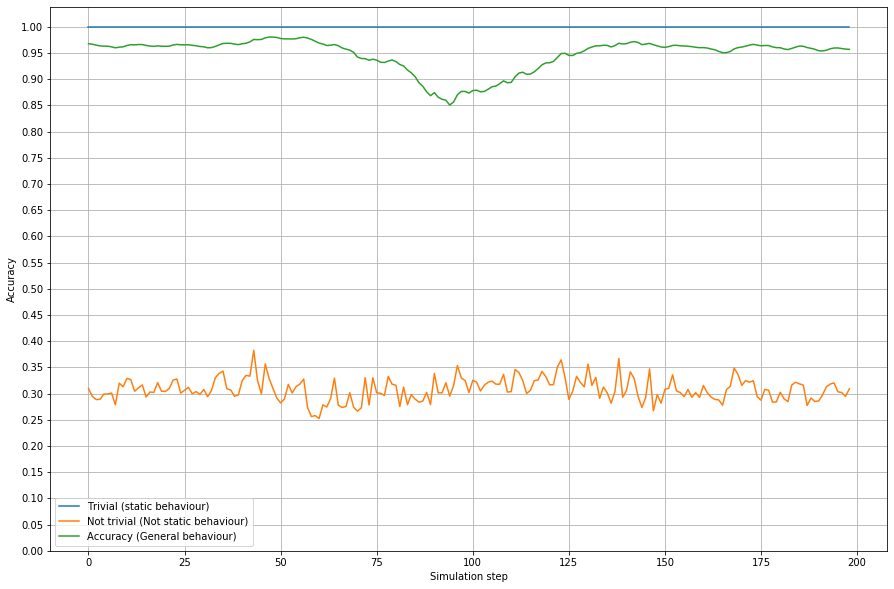

In [15]:
test2.plot()

<module 'matplotlib.pyplot' from '/Users/hectormoreno/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

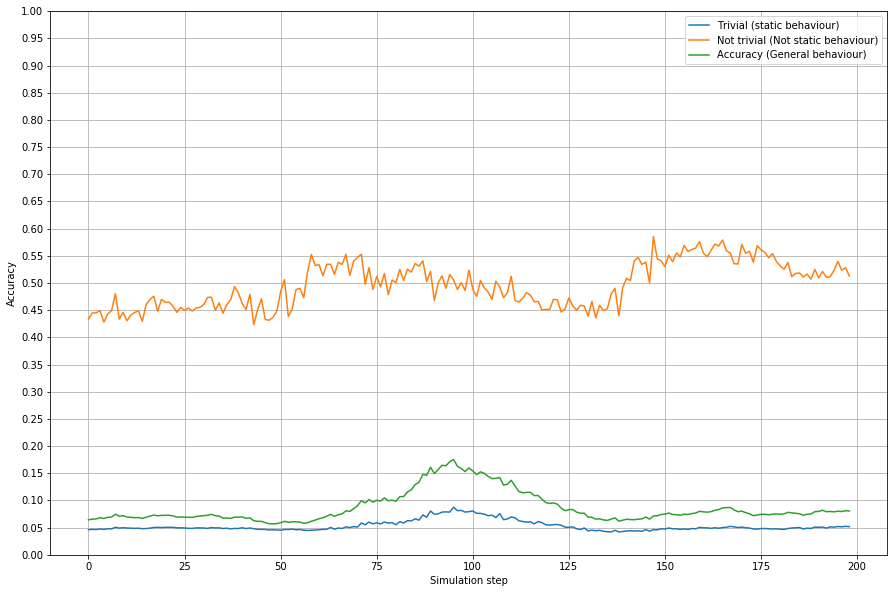

In [51]:
test3.plot()

In [52]:
results_path = f"{modelGGA.path}/{modelGGA.date}"
if test1 != None:
    np.savetxt(f"{results_path}/ocat.csv",test1.result,delimiter=",",header="trivial,nontrivial,accuracy")
if test2 != None:
    np.savetxt(f"{results_path}/gga.csv",test2.result,delimiter=",",header="trivial,nontrivial,accuracy")
if test3 != None:
    np.savetxt(f"{results_path}/nuggets.csv",test3.result,delimiter=",",header="trivial,nontrivial,accuracy")

NameError: name 'modelGGA' is not defined

In [36]:
np.savetxt(f"nuggets.csv",test3.result,delimiter=",",header="trivial,nontrivial,accuracy")

In [27]:
np.shape(data)

(1590000, 10)

In [95]:
res,mn,mx,rows,conflicts = helpers2.getBinaryStrings(data,data.shape[1]-1)

getting domains
get row number function
lambda x0,x1,x2,x3,x4,x5,x6,x7,x8:6561*x0+2187*x1+729*x2+243*x3+81*x4+27*x5+9*x6+3*x7+1*x8
lambda domain,x:[domain[0][x[0]],domain[1][x[1]],domain[2][x[2]],domain[3][x[3]],domain[4][x[4]],domain[5][x[5]],domain[6][x[6]],domain[7][x[7]],domain[8][x[8]]]
building binary strings
19682 0
string for key1
string for key2
string for key3


In [96]:
from pybdm import BDM 
bdm = BDM(ndim=1)
for k in res:
    val = bdm.bdm(res[k], normalized=True)
    print(k,val)

total 0.012355673675453357
1 0.011035538775772447
2 0.008979131678445773
3 0.00955968256579402


In [94]:
from pybdm.algorithms import PerturbationExperiment
perturbation = PerturbationExperiment(bdm, res[1], metric='bdm')
delta_bdm = perturbation.run()

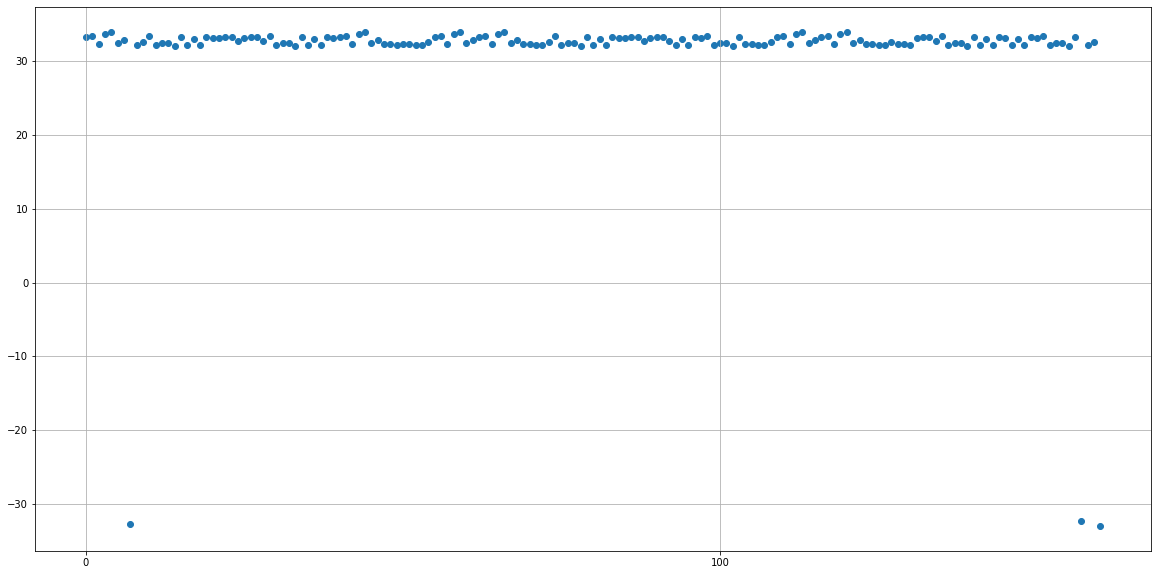

In [117]:
plt.figure(figsize=(20,10))
aux =list(filter(lambda x: x > 32 or x < -32 ,delta_bdm))
plt.scatter(range(len(aux)),aux)
plt.xticks(np.arange(0,len(aux),step=100))
plt.grid(True)
plt.show()

In [105]:
delta_bdm

array([0.15199218, 0.04438321, 0.15199218, ..., 0.09952476, 0.12551997,
       0.04063108])

In [83]:
mn,mx

(0, 19682)

In [86]:
import math
noMinVars = math.ceil(math.log2(mx))
noMinVars

15

In [87]:
domains = {}
target = noMinVars+1
for i in range(noMinVars+1):
    domains[i] = [0,1]
expr =helpers2.getExpr(domains,target)

lambda x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15:32768*x0+16384*x1+8192*x2+4096*x3+2048*x4+1024*x5+512*x6+256*x7+128*x8+64*x9+32*x10+16*x11+8*x12+4*x13+2*x14+1*x15


In [88]:
val = 0
other = 19682
vals = np.zeros(shape=(noMinVars+1),dtype=np.int)
currIndex = 0
while val != other:
    vals[currIndex] = 1
    val = expr(*vals)
    if val > other:
        vals[currIndex] = 0
        val = expr(*vals)
    currIndex += 1
        

In [89]:
vals

array([0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0])

In [ ]:
def newBinarize(mx,)

In [85]:
rows

{1: {0,
  1,
  2,
  4,
  8,
  9,
  12,
  13,
  14,
  17,
  18,
  22,
  24,
  25,
  26,
  28,
  56,
  112,
  252,
  336,
  364,
  392,
  504,
  616,
  729,
  756,
  757,
  758,
  768,
  769,
  770,
  780,
  781,
  782,
  785,
  1065,
  1093,
  1121,
  1458,
  1486,
  1512,
  1513,
  1514,
  1524,
  1525,
  1526,
  1536,
  1537,
  1538,
  1794,
  1822,
  1850,
  2916,
  3024,
  3028,
  3032,
  3033,
  3037,
  3041,
  3042,
  3046,
  3050,
  3168,
  3280,
  3420,
  3532,
  5832,
  5944,
  6084,
  6196,
  6336,
  6448,
  6561,
  6673,
  6804,
  6808,
  6812,
  6813,
  6817,
  6821,
  6822,
  6826,
  6830,
  6925,
  7065,
  7177,
  8748,
  8776,
  8804,
  9072,
  9073,
  9074,
  9084,
  9085,
  9086,
  9096,
  9097,
  9098,
  9112,
  9140,
  9477,
  9505,
  9533,
  9589,
  9729,
  9813,
  9828,
  9829,
  9830,
  9832,
  9836,
  9837,
  9840,
  9841,
  9846,
  9852,
  9854,
  9981,
  10206,
  10234,
  10262,
  10542,
  10584,
  10585,
  10586,
  10596,
  10598,
  10608,
  10609,
  10610,
  1